In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import numpy as np
import os

In [2]:
plt.rc('legend', fontsize=10)
#plt.rc('text', usetex=True)

In [169]:
# option 1: /separate runs/*.dat (NeuroML2)
dt = 0.001
threshold = -0.025
dat_files = [f for f in os.listdir('separate runs') if os.path.isfile(os.path.join('separate runs', f)) and os.path.splitext(f)[1] == '.dat']
currents = np.array([float(f[:-6]) for f in dat_files])  # pA
spike_trains = []
for f in dat_files:
    t, v, i = np.genfromtxt(os.path.join('separate runs', f)).transpose()
    spike_trains.append(v)
#zip(dat_files, currents)

In [ ]:
# option 2: increasing.dat (XPP)
spike_trains = []
dt = 0.1
threshold = -25
t, v = np.genfromtxt('increasing.dat').transpose()[:2]
for start in range(int(3050/dt), int(10051/dt), int(500/dt)):
    spike_trains.append(v[start:start+int(400/dt)])  # trim start and end to prevent any spikes from other current steps
currents = np.array([-1.9, -1.7, -1.2, -0.5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [ ]:
# option 3: decreasing.dat (XPP)
spike_trains = []
dt = 0.1
threshold = -25
t, v = np.genfromtxt('decreasing.dat').transpose()[:2]
for start in range(int(50/dt), int(7551/dt), int(500/dt)):
    spike_trains.append(v[start:start+int(400/dt)])  # trim start and end to prevent any spikes from other current steps
currents = np.array([50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, -1.2 , -1.9, -2.4, -2.7, -2.72])
#spike_trains

In [4]:
ms_to_index = lambda ms: int(ms / dt)  # TODO: Make this better
index_to_ms = lambda ind: ind * dt

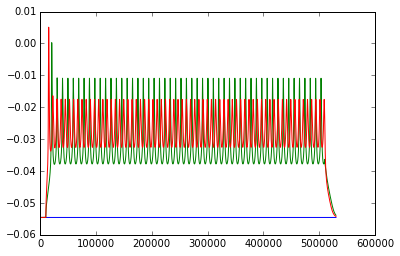

In [5]:
for s in spike_trains[::5]:
    plt.plot(s)

Ipulse = 5.0 pA


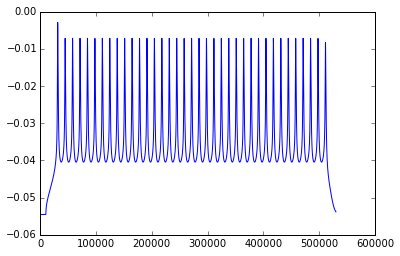

In [183]:
i = 13
plt.plot(spike_trains[i])
#plt.xlim(157000, 185000)
print 'Ipulse =', currents[i], 'pA'

In [170]:
spike_times = []
for spike_train in spike_trains:
    current_spike_times = []
    for i in range(spike_train.size-1):
        if spike_train[i] < threshold and spike_train[i+1] >= threshold:
            current_spike_times.append(index_to_ms(i))
    spike_times.append(np.array(current_spike_times))
spike_times

[array([ 157.348,  185.142,  212.935,  240.723,  268.508,  296.291,
         324.073,  351.853,  379.632,  407.41 ,  435.188,  462.965,  490.742]),
 array([ 336.717,  367.708,  398.688,  429.662,  460.632,  491.601]),
 array([  98.678,  122.964,  147.262,  171.555,  195.845,  220.134,
         244.422,  268.709,  292.995,  317.28 ,  341.565,  365.849,
         390.133,  414.417,  438.7  ,  462.983,  487.266,  512.209]),
 array([  63.649,   83.879,  104.135,  124.387,  144.638,  164.887,
         185.135,  205.383,  225.63 ,  245.876,  266.122,  286.368,
         306.614,  326.859,  347.104,  367.349,  387.593,  407.838,
         428.083,  448.327,  468.571,  488.816,  509.06 ]),
 array([  23.212,   34.165,   45.103,   56.046,   66.988,   77.931,
          88.873,   99.815,  110.757,  121.699,  132.641,  143.583,
         154.525,  165.467,  176.409,  187.351,  198.292,  209.234,
         220.176,  231.117,  242.059,  253.   ,  263.942,  274.884,
         285.825,  296.766,  307.708,  3

In [ ]:
durations = [times[1:] - times[:-1] for times in spike_times]  # time between spikes, ms
frequencies = [1000. / d for d in durations]  # Hz

In [ ]:
mean_frequencies = map(np.mean, frequencies)
sem_frequencies = map(sp.stats.sem, frequencies)
zip(mean_frequencies, sem_frequencies)

In [ ]:
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(11.4, 120, '10.1 pA', color='b', rotation=90)
plt.axvline(-2.73+12, label="Rheobase (tonic -> silence)", color='g', alpha=0.6)
plt.text(6.5, 120, '9.27 pA', color='g', rotation=90)
plt.errorbar(currents+12, mean_frequencies, yerr=sem_frequencies, fmt='b>', capsize=7, label="Increasing current steps", markeredgecolor='none')
plt.arrow(25, 115, 8, 15, head_width=2, head_length=3, fc='b', ec='b')
plt.errorbar(currents_2+12, mean_frequencies_2, yerr=sem_frequencies_2, fmt='g<', capsize=7, label="Decreasing current steps", markeredgecolor='none')
plt.arrow(40, 110, -8, -15, head_width=2, head_length=3, fc='g', ec='g')
#plt.axvspan(0, -1.9+12, edgecolor='none', alpha=0.1, label="No spiking")

plt.ylim(0, 150)
plt.xlim(0, 70)
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Firing rate / Hz')
plt.legend(loc='lower right', numpoints=1, borderaxespad=3, frameon=False)

fit = np.poly1d(np.polyfit(currents+12, mean_frequencies, 3))
x = np.linspace(1, 70)
#plt.plot(x, fit(x), 'black', linewidth=0.3)

#plt.savefig("plot.png", dpi=300)

In [ ]:
mean_frequencies_2 = mean_frequencies
sem_frequencies_2 = sem_frequencies
currents_2 = currents

In [ ]:
for sem, mean in zip(sem_frequencies_2, mean_frequencies_2):
    print sem / mean

In [171]:
# delay to first spike
spike_delays = [t[0] - 10 if len(t) > 0 else np.nan for t in spike_times]  # current pulse starts at 10 ms
spike_delays

[147.34800000000001,
 326.71699999999998,
 88.677999999999997,
 53.649000000000001,
 13.212,
 9.8360000000000021,
 7.8680000000000021,
 6.5689999999999991,
 5.6419999999999995,
 4.9459999999999997,
 4.402000000000001,
 3.9649999999999999,
 3.604000000000001,
 20.553000000000001]

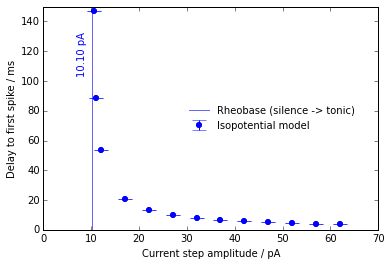

In [193]:
plt.errorbar(currents+12, spike_delays, yerr=0.001, fmt='o', capsize=7, markeredgecolor='none', label='Isopotential model')
plt.xlim(0, 70)
plt.ylim(0, 150)
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Delay to first spike / ms')
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, 128, '10.10 pA', color='b', rotation=90)
plt.legend(loc='center right', numpoints=1, borderaxespad=2, frameon=False)
plt.savefig("delay.png", dpi=300)

In [184]:
# spike minima, maxima, amplitudes
spike_maxima = []
spike_minima = []
spike_amplitudes = []
for spike_train, times in zip(spike_trains, spike_times):
    current_spike_maxima = []
    current_spike_minima = []
    current_spike_amplitudes = []
    for i in range(2, len(times)-3):  # exclude first two and last spikes to exclude border effects
        start = ms_to_index(times[i])
        end = ms_to_index(times[i+1])
        voltage_trace = spike_train[start:end] * 1000  # in mV
        minimum = np.min(voltage_trace)
        maximum = np.max(voltage_trace)
        current_spike_maxima.append(minimum)
        current_spike_minima.append(maximum)
        current_spike_amplitudes.append(maximum - minimum)
    spike_minima.append(np.array(current_spike_minima))
    spike_maxima.append(np.array(current_spike_maxima))
    spike_amplitudes.append(np.array(current_spike_amplitudes))

In [185]:
mean_spike_minima = map(np.mean, spike_minima)
sem_spike_minima = map(sp.stats.sem, spike_minima)
mean_spike_maxima = map(np.mean, spike_maxima)
sem_spike_maxima = map(sp.stats.sem, spike_maxima)
mean_spike_amplitudes = map(np.mean, spike_amplitudes)
sem_spike_amplitudes = map(sp.stats.sem, spike_amplitudes)
#mean_spike_amplitudes

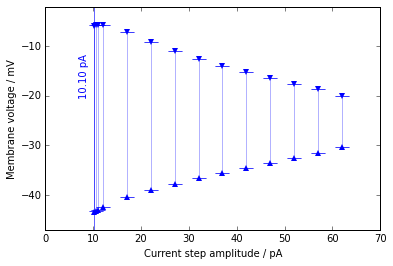

In [208]:
plt.errorbar(currents+12, mean_spike_minima, yerr=sem_spike_minima, fmt='v', color='b', capsize=7, markeredgecolor='none', label='Mean minimum during spike')
plt.errorbar(currents+12, mean_spike_maxima, yerr=sem_spike_maxima, fmt='^', color='b', capsize=7, markeredgecolor='none', label='Mean maximum during spike')

plt.vlines(currents+12, mean_spike_minima, mean_spike_maxima, alpha=0.3, color='b')

plt.xlabel('Current step amplitude / pA')
plt.ylabel('Membrane voltage / mV')
plt.xlim(0, 70)
plt.ylim(-47, -2)
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, -13, '10.10 pA', color='b', rotation=90)
#plt.legend(loc='upper right', numpoints=1, borderaxespad=0, frameon=False)
plt.savefig("min_max.png", dpi=300)

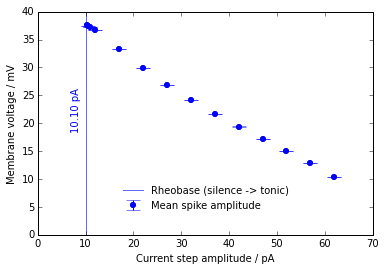

In [205]:
plt.errorbar(currents+12, mean_spike_amplitudes, yerr=sem_spike_amplitudes, fmt='o', capsize=7, markeredgecolor='none', label='Mean spike amplitude')
plt.xlabel('Current step amplitude / pA')
plt.ylabel('Membrane voltage / mV')
plt.xlim(0, 70)
plt.ylim(0, 40)
plt.axvline(-1.90+12, label="Rheobase (silence -> tonic)", color='b', alpha=0.6)
plt.text(7, 25, '10.10 pA', color='b', rotation=90)
plt.legend(loc='lower center', numpoints=1, borderaxespad=2, frameon=False)

fit = np.poly1d(np.polyfit(currents+12, np.array(mean_spike_amplitudes), 1))
x = np.linspace(1, 70)
#plt.plot(x, fit(x), 'black', linewidth=0.3)

plt.savefig("amplitudes.png", dpi=300)